In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
predictions = pd.read_csv('mayag_etal_zf_proteinBERT_predictions_wheldout_nosim.tsv', sep='\t')

In [3]:
#downstream_data = pd.read_csv('Downstream_APA_Validation.csv', index_col=0).dropna()
downstream_data = pd.read_csv('Downstream_APA.csv', index_col=0).dropna()
#downstream_data = downstream_data[(downstream_data['p-value'] < 0.05)| (downstream_data['Symbol'] =='FLAG NC')]

In [4]:
#upstream_data = pd.read_csv('Upstream_APA_Validation.csv', index_col=0).dropna()
upstream_data = pd.read_csv('Upstream_APA.csv', index_col=0).dropna()
#upstream_data = upstream_data[(upstream_data['p-value'] < 0.05) | (upstream_data['Symbol'] =='FLAG NC')]

In [5]:
common_gene_set =  list(set(predictions['Protein']).intersection(set(downstream_data['Symbol']),set(upstream_data['Symbol']))) + ['FLAG NC']

In [6]:
def assign_significance(df):
    if df['p-value'] < 0.005:
        return '***'
    elif df['p-value'] < 0.01:
        return '**'
    elif df['p-value'] < 0.05:
        return '*'
    else:
        return 'ns'

In [7]:
upstream_data['stars'] = upstream_data.apply(assign_significance, axis=1)

In [8]:
upstream_stars_dict = dict(zip(upstream_data.Symbol, upstream_data.stars))

In [9]:
downstream_data['stars'] = downstream_data.apply(assign_significance, axis=1)

In [10]:
downstream_stars_dict = dict(zip(downstream_data.Symbol, downstream_data.stars))

In [11]:
def make_screen_dataframe(df):
    screen_data = []
    for index,row in df.iterrows():
        vals = [float(v) for v in row['Value'].strip('[').strip(']').split(', ')]
        screen_data.append([row['Symbol'], np.log2(vals[0]), 'rep1'])
        screen_data.append([row['Symbol'], np.log2(vals[1]), 'rep2'])
        screen_data.append([row['Symbol'], np.log2(vals[2]), 'rep3'])
    return pd.DataFrame(screen_data)


In [12]:
down_data = make_screen_dataframe(downstream_data)

In [13]:
up_data = make_screen_dataframe(upstream_data)

In [14]:
from matplotlib_venn import venn2, venn3

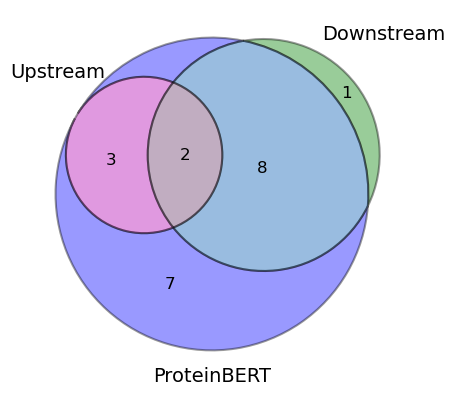

In [15]:
activator_up = set(upstream_data[(upstream_data['Symbol'].isin(common_gene_set)) & (upstream_data['mean']>1) & (upstream_data['p-value']<0.05)]['Symbol'])
activator_down = set(downstream_data[(downstream_data['Symbol'].isin(common_gene_set)) & (downstream_data['mean']>1) & (downstream_data['p-value']<0.05)]['Symbol'])
proteinbert_activators = set(predictions[(predictions['Protein'].isin(common_gene_set)) & (predictions['ProteinBERT_score'] > 0.15)]['Protein'])

venn1 = venn3([activator_up, activator_down, proteinbert_activators], ('Upstream', 'Downstream', 'ProteinBERT'))

# Make outline thicker
for patch in venn1.patches:
    if patch:  # some subsets might be None
        patch.set_linewidth(1.5)   # thickness
        patch.set_edgecolor("black")

# Lower fill alpha (more transparent)
for patch in venn1.patches:
    if patch:
        patch.set_alpha(0.4)   # 0=fully transparent, 1=opaque

# Make font bigger
for label in venn1.set_labels:
    label.set_fontsize(14)   # set font size of set labels
for label in venn1.subset_labels:
    if label:  # some subsets may be None
        label.set_fontsize(12)   # set font size of subset labels
# plt.savefig('activator_venn_proteinbert_prediction.png')
# plt.savefig('activator_venn_proteinbert_prediction.svg')
# plt.savefig('activator_venn_proteinbert_prediction.jpg')

plt.show()

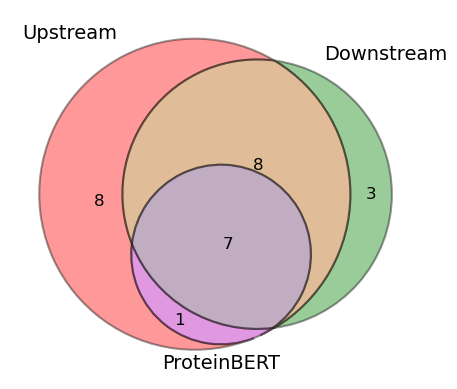

In [16]:
non_activator_up = set(upstream_data[(upstream_data['Symbol'].isin(common_gene_set)) & (~upstream_data['Symbol'].isin(activator_up))]['Symbol'])
non_activator_down =  set(downstream_data[(downstream_data['Symbol'].isin(common_gene_set)) & (~downstream_data['Symbol'].isin(activator_down))]['Symbol'])
proteinbert_nonactivator = set(predictions[(predictions['Protein'].isin(common_gene_set)) & (predictions['ProteinBERT_score'] < 0.15)]['Protein'])

venn = venn3([non_activator_up, non_activator_down, proteinbert_nonactivator], ('Upstream', 'Downstream', 'ProteinBERT'))


# Make outline thicker
for patch in venn.patches:
    if patch:  # some subsets might be None
        patch.set_linewidth(1.5)   # thickness
        patch.set_edgecolor("black")

# Lower fill alpha (more transparent)
for patch in venn.patches:
    if patch:
        patch.set_alpha(0.4)   # 0=fully transparent, 1=opaque

# Make font bigger
for label in venn.set_labels:
    label.set_fontsize(14)   # set font size of set labels
for label in venn.subset_labels:
    if label:  # some subsets may be None
        label.set_fontsize(12)   # set font size of subset labels
# plt.savefig('nonactivator_venn_proteinbert_prediction.png')
# plt.savefig('nonactivator_venn_proteinbert_prediction.svg')
# plt.savefig('nonactivator_venn_proteinbert_prediction.jpg')

plt.show()

In [17]:
positives = activator_up.union(activator_down)

In [18]:
TP = len(proteinbert_activators.intersection(positives))

In [19]:
FP = len(proteinbert_activators- positives)

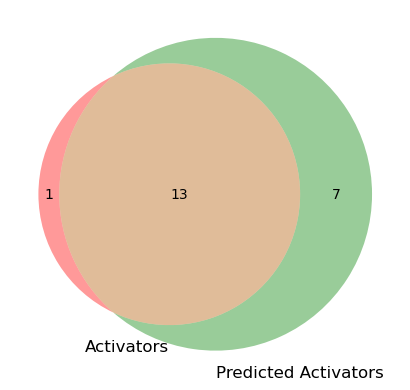

In [20]:
venn2([positives, proteinbert_activators], ('Activators', 'Predicted Activators'))

In [21]:
negatives = non_activator_up.union(non_activator_down) - positives

In [22]:
TN = len(proteinbert_nonactivator.intersection(negatives))

In [23]:
FN = len(proteinbert_nonactivator - negatives)

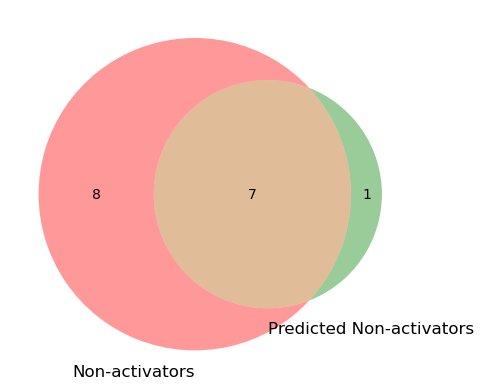

In [24]:
venn2([negatives, proteinbert_nonactivator], ('Non-activators', 'Predicted Non-activators'))

In [25]:
Total = TP + FP + TN + FN

Precision = TP / (TP + FP) 

Recall = TP / (TP + FN)

Specificity = TN / (TN + FP)

Accuracy = (TP + TN) / Total

print(f'Precision:{Precision}')
print(f'Recall (Sensitivity):{Recall}')
print(f'Specificity:{Specificity}')
print(f'Accuracy:{Accuracy}')

Precision:0.65
Recall (Sensitivity):0.9285714285714286
Specificity:0.5
Accuracy:0.7142857142857143


/scratch/pjaganna1/job_7130581/ipykernel_484218/1495526344.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


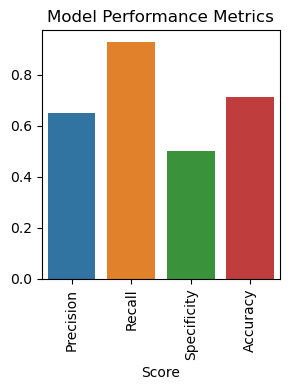

In [26]:
metrics = ['Precision', 'Recall', 'Specificity', 'Accuracy']
values = [Precision, Recall, Specificity, Accuracy]

plt.figure(figsize=(3, 4))  # narrower width, taller height
sns.barplot(
    x=metrics,          # vertical labels
    y=values,           # horizontal bars
    palette="tab10"      # use Set1 color palette
)

plt.xlabel("Score")
plt.xticks(rotation=90);
plt.ylabel("")   # cleaner look
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.show()

In [27]:
def add_stars_to_plot(ax, stars_dict):
    # Loop through bars
    for i, patch in enumerate(ax.patches):
        protein_name = ax.get_xticklabels()[i].get_text()
        if protein_name in stars_dict:
            if stars_dict[protein_name] !='ns':
                bar_height = patch.get_height()
                if bar_height >= 0:
                    ax.text(
                        patch.get_x() + patch.get_width() / 2,
                        bar_height + 0.2,              # slightly above the bar
                        stars_dict[protein_name],
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='red'
                    )
                else:
                    ax.text(
                        patch.get_x() + patch.get_width() / 2,
                        bar_height - 0.35,              # slightly above the bar
                        stars_dict[protein_name],
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='red'
                    )

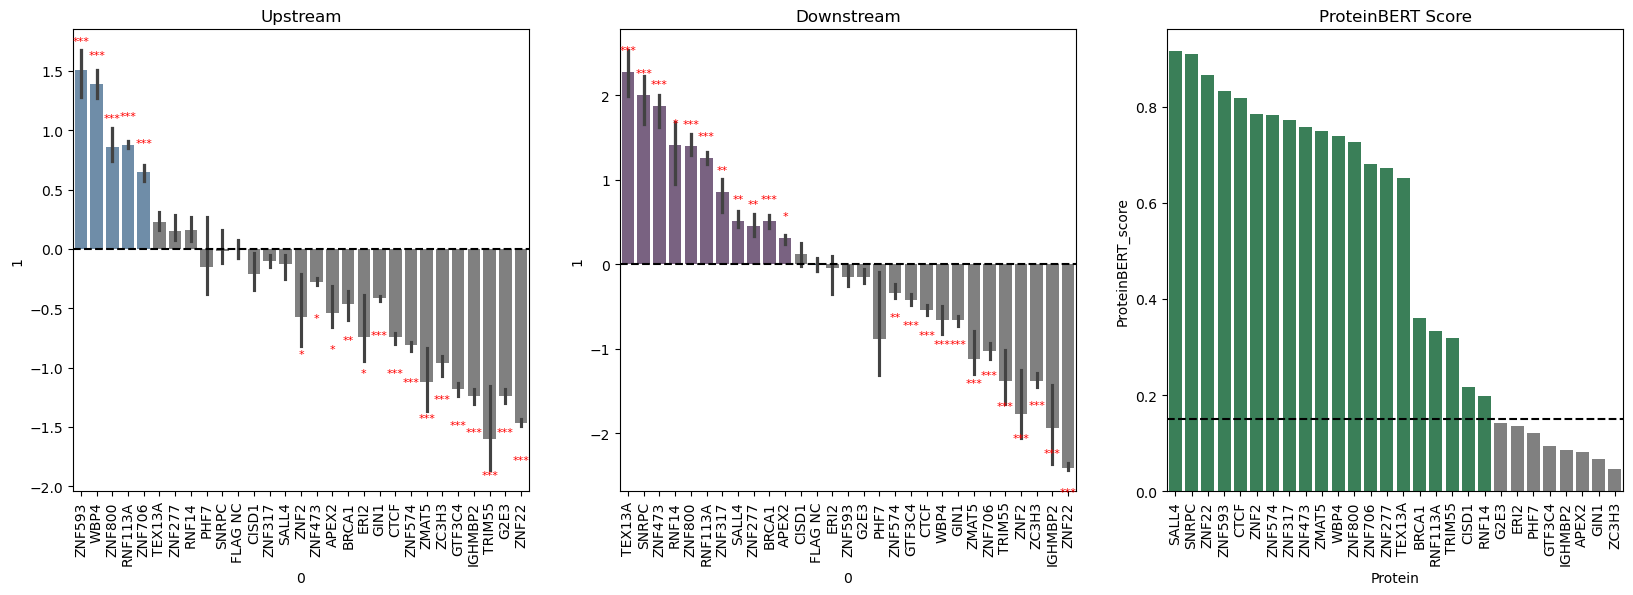

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.barplot(data=up_data[up_data[0].isin(common_gene_set)].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[0], color='grey')
add_stars_to_plot(axes[0], upstream_stars_dict)
sns.barplot(data=up_data[up_data[0].isin(activator_up)].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[0], color='#668EB1')

sns.barplot(data=up_data[up_data[0]=='FLAG NC'].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[0])

axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Upstream')
axes[0].tick_params(axis='x', labelrotation=90) 

sns.barplot(data=down_data[down_data[0].isin(common_gene_set)].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[1], color='grey')
add_stars_to_plot(axes[1], downstream_stars_dict)
sns.barplot(data=down_data[down_data[0].isin(activator_down)].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[1], color='#7C5D86')
sns.barplot(data=down_data[down_data[0]=='FLAG NC'].sort_values(1, ascending=False),
            x=0,
            y=1, ax=axes[1])
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('Downstream')
axes[1].tick_params(axis='x', labelrotation=90) 

sns.barplot(data=predictions[predictions['Protein'].isin(common_gene_set)].sort_values('ProteinBERT_score', ascending=False),
            x='Protein',
            y='ProteinBERT_score', ax=axes[2], color='grey')
sns.barplot(data=predictions[predictions['Protein'].isin(proteinbert_activators)].sort_values('ProteinBERT_score', ascending=False),
            x='Protein',
            y='ProteinBERT_score', ax=axes[2], color='seagreen')
axes[2].axhline(0.15, color='black', linestyle='--')
axes[2].set_title('ProteinBERT Score')
axes[2].tick_params(axis='x', labelrotation=90, ) 

In [29]:
up_data_plot = up_data.copy()
down_data_plot = down_data.copy()

In [30]:
up_data_plot['reporter'] = 'Upstream'
up_data_plot['Activator'] = up_data_plot.apply(lambda x: x[0] in activator_up, axis=1)
up_data_plot['stars'] = up_data_plot[0].map(upstream_stars_dict)

down_data_plot['reporter'] = 'Downstream'
down_data_plot['Activator'] = down_data_plot.apply(lambda x: x[0] in activator_down, axis=1)
down_data_plot['stars'] = down_data_plot[0].map(upstream_stars_dict)

up_down_concat = pd.concat([up_data_plot, down_data_plot])
up_down_concat['sig'] = up_down_concat['stars'] != 'ns'

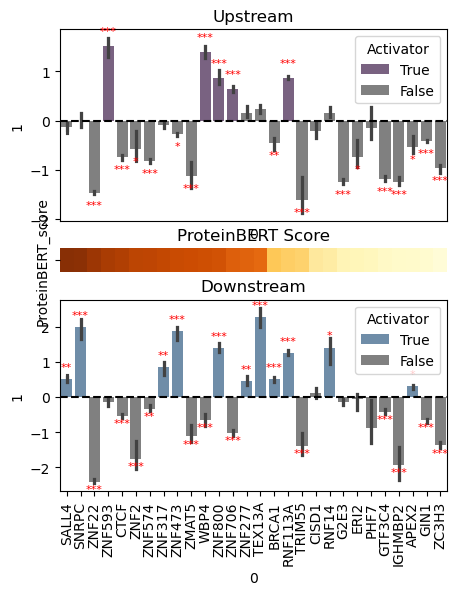

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), gridspec_kw={'height_ratios': [2, 0.25, 2]})

protein_order = (
    predictions[predictions['Protein'].isin(common_gene_set)]
    .sort_values('ProteinBERT_score', ascending=False)['Protein']
    .tolist()
)

# --- Upstream ---
up_down_concat = up_down_concat.copy()

up_down_concat[0] = pd.Categorical(up_down_concat[0], categories=protein_order, ordered=True)

sns.barplot(data=up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Upstream')],
            x=0,
            y=1, ax=axes[0], color='grey')
add_stars_to_plot(axes[0], upstream_stars_dict)
sns.barplot(data=up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Upstream')],
            x=0,
            y=1, 
            hue='Activator',
            ax=axes[0], palette=['#7C5D86', 'grey'], hue_order=[True, False])



axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('Upstream')
#axes[0].tick_params(axis='x', labelrotation=90) 
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# --- Downstream ---

sns.barplot(data=up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Downstream')],
            x=0,
            y=1, ax=axes[2], color='grey')
add_stars_to_plot(axes[2], downstream_stars_dict)
sns.barplot(data=up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Downstream')],
            x=0,
            y=1, 
            hue='Activator',
            ax=axes[2], palette=['#668EB1', 'grey'], hue_order=[True, False])



axes[2].axhline(0, color='black', linestyle='--')
axes[2].set_title('Downstream')
axes[2].tick_params(axis='x', labelrotation=90) 


# --- ProteinBERT Score heatmap ---
score_data = predictions[predictions['Protein'].isin(common_gene_set)]
score_data = score_data.set_index('Protein').loc[protein_order]  # align to order

sns.heatmap(
    score_data[['ProteinBERT_score']].T,  # transpose so proteins are columns
    ax=axes[1],
    cmap='YlOrBr',
    cbar_kws={'label': 'ProteinBERT Score'}, cbar=None, vmin=0, vmax=1
)

axes[1].set_title('ProteinBERT Score')
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.savefig('zf_prediction_results.png')
# plt.savefig('zf_prediction_results.svg')
# plt.savefig('zf_prediction_results.jpg')

In [32]:
up_down_concat

,0,1,2,reporter,Activator,stars,sig
0,NaN,0.110724,rep1,Upstream,False,ns,False
1,NaN,-0.046095,rep2,Upstream,False,ns,False
2,NaN,-0.071458,rep3,Upstream,False,ns,False
3,NaN,3.457590,rep1,Upstream,False,***,True
4,NaN,3.450443,rep2,Upstream,False,***,True
...,...,...,...,...,...,...,...
151,ZNF800,1.372197,rep2,Downstream,True,***,True
152,ZNF800,1.296549,rep3,Downstream,True,***,True
153,NaN,-0.219897,rep1,Downstream,False,ns,False
154,NaN,-0.282636,rep2,Downstream,False,ns,False


In [33]:
to_plot_heatmap = predictions[predictions['Protein'].isin(common_gene_set)][['Protein', 'ProteinBERT_score']].set_index('Protein').sort_values(by='ProteinBERT_score', ascending=False).merge(up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Downstream')][[0, 'Activator']].drop_duplicates().set_index(0),
                                                                                     right_index=True,
                                                                                     left_index=True).merge(up_down_concat[(up_down_concat[0].isin(common_gene_set)) & (up_down_concat['reporter']=='Upstream')][[0, 'Activator']].drop_duplicates().set_index(0),
                                                                                                            right_index=True,
                                                                                                             left_index=True, suffixes=['_upstream', '_downstream'])

In [34]:
to_plot_heatmap.T

,SALL4,SNRPC,ZNF22,ZNF593,CTCF,ZNF2,ZNF574,ZNF317,ZNF473,ZMAT5,...,CISD1,RNF14,G2E3,ERI2,PHF7,GTF3C4,IGHMBP2,APEX2,GIN1,ZC3H3
ProteinBERT_score,0.914607,0.908709,0.866381,0.833276,0.818662,0.785484,0.782166,0.772536,0.756832,0.749947,...,0.217933,0.198297,0.142372,0.135141,0.122203,0.094017,0.08564,0.081289,0.067658,0.046689
Activator_upstream,True,True,False,False,False,False,False,True,True,False,...,False,True,False,False,False,False,False,True,False,False
Activator_downstream,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
proteinbert_df.dtypes

NameError: name 'proteinbert_df' is not defined

/scratch/pjaganna1/job_7130581/ipykernel_484218/2729531536.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


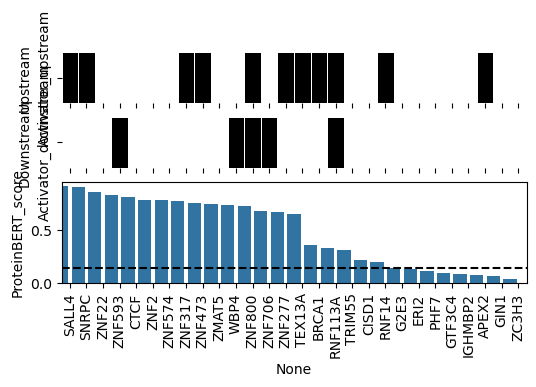

In [70]:
df = to_plot_heatmap.T.copy()
# Convert True/False to 1/0 for activator rows
binary_rows = ["Activator_upstream", "Activator_downstream"]
df.loc[binary_rows] = df.loc[binary_rows].astype(int)

# Separate continuous (ProteinBERT) and binary rows
proteinbert_df = df.loc[["ProteinBERT_score"]]
proteinbert_df = proteinbert_df.apply(pd.to_numeric, errors='coerce')
binary_df = df.loc[binary_rows]
binary_df = binary_df.apply(pd.to_numeric, errors='coerce')

# Plot side-by-side heatmaps as subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 3), 
                         gridspec_kw={'height_ratios': [0.25, 0.25, 0.5]}, 
                         sharex=True)

# ProteinBERT score heatmap
# sns.heatmap(proteinbert_df, cmap="Blues", cbar=False, ax=axes[2])
# axes[2].set_ylabel("ProteinBERT Score")

sns.barplot(x=proteinbert_df.T.index,
            y=proteinbert_df.T.ProteinBERT_score
           )

# Binary heatmaps
sns.heatmap(binary_df.loc[["Activator_upstream"]], cmap="binary", cbar=False, linewidth=0.5,ax=axes[0])
axes[0].set_ylabel("Upstream")

sns.heatmap(binary_df.loc[["Activator_downstream"]], cmap="binary", cbar=False , linewidth=0.5, ax=axes[1])
axes[1].set_ylabel("Downstream")

# axes[0].axvline(x=20, linestyle='--', color='black')
# axes[1].axvline(x=20, linestyle='--', color='black')
axes[2].axhline(y=0.15, linestyle='--', color='black')
plt.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [40]:
to_plot_heatmap['Activator'] = (
    to_plot_heatmap['Activator_upstream'].astype(bool) |
    to_plot_heatmap['Activator_downstream'].astype(bool)
)

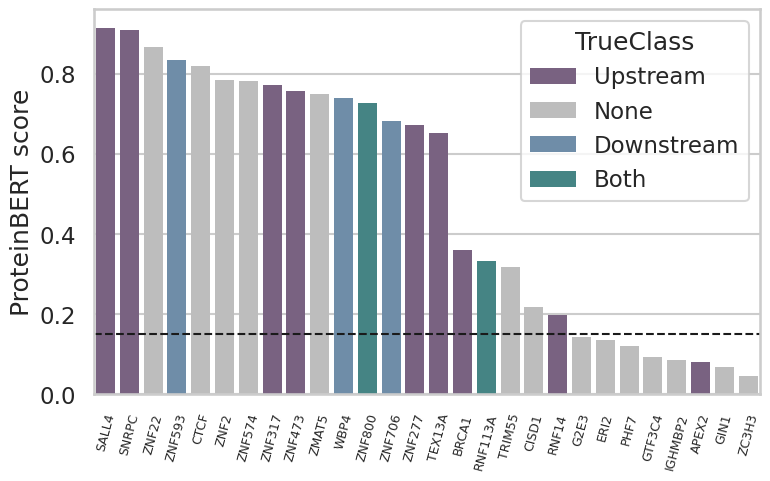

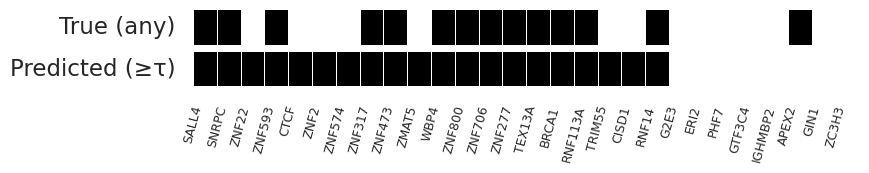

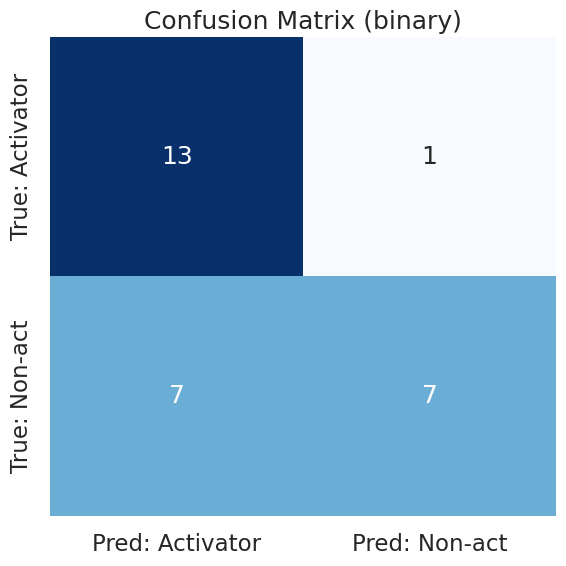

Confusion Matrix:
[[13  1]
 [ 7  7]]
TN=4, FP=1, FN=1, TP=4

Metrics:
Precision: 0.650
Recall:    0.929
Accuracy:  0.714
F1 Score:  0.765


In [100]:
from sklearn.metrics import confusion_matrix

# ------------------------------------------------------------------
# 0) Prepare table (your object has rows as columns; we transpose)
# ------------------------------------------------------------------
df = to_plot_heatmap.copy()  # rows -> proteins; cols -> ['ProteinBERT_score','Activator_upstream','Activator_downstream']

# ensure numeric/bool dtypes
df['ProteinBERT_score']   = pd.to_numeric(df['ProteinBERT_score'], errors='coerce')
df['Activator_upstream']   = df['Activator_upstream'].astype(bool)
df['Activator_downstream'] = df['Activator_downstream'].astype(bool)

# threshold for calling "Predicted Activator"
tau = 0.15  # <== set your threshold here

# ------------------------------------------------------------------
# 1) True class labels (Upstream/Downstream/Both/None) + order
# ------------------------------------------------------------------
u  = df['Activator_upstream']
d  = df['Activator_downstream']
true_any = (u | d)

true_multiclass = np.select(
    [u & ~d, ~u & d, u & d, ~u & ~d],
    ['Upstream', 'Downstream', 'Both', 'None']
)

df['TrueClass']     = true_multiclass
df['TrueAny']       = true_any.astype(int)               # 1/0
df['PredictedAny']  = (df['ProteinBERT_score'] >= tau).astype(int)

# order proteins by score (desc)
prot_order = df.sort_values('ProteinBERT_score', ascending=False).index.tolist()

# colorblind-friendly palette for true classes
true_palette = {
    'Upstream':   '#7C5D86',  # purple
    'Downstream': '#668EB1',  # blue
    'Both':       '#3B8E8E',  # teal
    'None':       '#BDBDBD'   # gray
}

# ------------------------------------------------------------------
# BARPLOT + HEATMAP STRIPS with shared x
# ------------------------------------------------------------------
sns.set(context='talk', style='whitegrid')

# ------------------------------------------------------------------
# BARPLOT
# ------------------------------------------------------------------
plt.figure(figsize=(min(0.20*len(prot_order)+3, 18), 5))  # narrower width, taller height

bar_df = df.loc[prot_order, ['ProteinBERT_score', 'TrueClass']].reset_index(names='Protein')
bar_plot = sns.barplot(
    data=bar_df, x='Protein', y='ProteinBERT_score',
    hue='TrueClass', palette=true_palette, dodge=False,
    order=prot_order,linewidth=0  # enforce same order
)
bar_plot.axhline(tau, ls='--', lw=1.5, color='k', label=f'Threshold = {tau:g}')
bar_plot.set_ylabel('ProteinBERT score')
bar_plot.set_xlabel('')
#bar_plot.legend(title='True class', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
bar_plot.tick_params(axis='x', labelrotation=75, labelsize=9)
#plt.tight_layout()
plt.savefig('zf_prediction_summary.png')
plt.savefig('zf_prediction_summary.svg')
plt.savefig('zf_prediction_summary.jpg')
plt.show()

# ------------------------------------------------------------------
# HEATMAP STRIPS
# ------------------------------------------------------------------
# build strips with same column order as barplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(min(0.20*len(prot_order)+3, 18), 1), 
                         gridspec_kw={'height_ratios': [0.6, 0.6], 'hspace':0.15}, 
                         sharex=True)
true_strip = pd.DataFrame([df.loc[prot_order, 'TrueAny'].values],
                          index=['True (any)'], columns=prot_order)
pred_strip = pd.DataFrame([df.loc[prot_order, 'PredictedAny'].values],
                          index=['Predicted (≥τ)'], columns=prot_order)

# Heatmap for true labels
sns.heatmap(true_strip, cmap='binary', vmin=0, vmax=1, cbar=False,
            linewidths=0.4, linecolor='white', ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_yticklabels(['True (any)'], rotation=0)
axes[0].set_xticks(range(len(prot_order)))
axes[0].set_xticklabels([], rotation=0)

# Heatmap for predicted labels
sns.heatmap(pred_strip, cmap='binary', vmin=0, vmax=1, cbar=False,
            linewidths=0.4, linecolor='white', ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_yticklabels(['Predicted (≥τ)'], rotation=0)
axes[1].set_xticks(range(len(prot_order)))
axes[1].set_xticklabels(prot_order, rotation=75, fontsize=9)

#plt.tight_layout()
plt.savefig('zf_prediction_summary_heatmap.png')
plt.savefig('zf_prediction_summary_heatmap.svg')
plt.savefig('zf_prediction_summary_heatmap.jpg')
plt.show()
# ------------------------------------------------------------------
# 4) (Optional) CONFUSION MATRIX for binary activator vs non-activator
# ------------------------------------------------------------------
y_true = df['TrueAny'].values
y_pred = df['PredictedAny'].values
cm = confusion_matrix(y_true, y_pred, labels=[1,0])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Activator','Pred: Non-act'],
            yticklabels=['True: Activator','True: Non-act'])
plt.title('Confusion Matrix (binary)')
plt.tight_layout()
plt.savefig('zf_prediction_summary_cm.png')
plt.savefig('zf_prediction_summary_cm.svg')
plt.savefig('zf_prediction_summary_cm.jpg')
plt.show()
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

print("Confusion Matrix:")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\nMetrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Accuracy:  {accuracy:.3f}")
print(f"F1 Score:  {f1:.3f}")

In [ ]:
›